# Setup

## Colab

In [ ]:
# # # Mount the drive and move to dir
# from google.colab import drive

# drive.mount("/content/drive")

In [ ]:
# # Switch to current dir
# %cd /content/drive/MyDrive/Coding/spread-res/runscr/

## Imports

In [2]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import os
import sys

import torch

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# from classes.models import BertPooler

# Import the utilities and the dataloader
from utils import inferutil, setuputil, trainutil

# Now reload the modules to ensure they are up-to-date
importlib.reload(setuputil)
importlib.reload(trainutil)
importlib.reload(inferutil)
# importlib.reload(BertPooler)

# Import the model
# from classes.models.BertPooler import BertPooler
from utils.inferutil import infer_full, infer_one

# Import the funcs needed from utils
from utils.setuputil import display_config, setup_config
from utils.trainutil import train_model

## Configuration

In [ ]:
input_config = {
    # Environment and Model Info
    "env": "local",
    "approach": "bert",
    "model_name": "BertPoolerPos",
    "model_base": "bert-base-cased",
    # System Configuration
    "device": "mps:0",
    "threads": 8,
    "seed": 0,
    # Data Configuration
    "data_dir": "../data",
    "data_ds": "manual",
    # Model Parameters
    "rows": 100,
    "cols": 100,
    "tokens": 32,
    # BERT Architecture Parameters
    "vocab_size": 30522,
    "hidden_size": 128,
    "num_hidden_layers": 1,
    "num_attention_heads": 1,
    "intermediate_size": 512,
    # Training Parameters
    "batch_size": 20,
    "lr": 1e-2,
    "mu": 0.25,
    "epochs": 3,
    "patience": 2,
    "save_int": 0,
    "save_dir": "../models/",
}
config = setup_config(input_config)
display_config(config)

# Define local variables from the config dictionary
DEVICE = config["DEVICE"]
THREADS = config["THREADS"]

# Data loaders and vocab
train_loader = config["train_loader"]
val_loader = config["val_loader"]
test_loader = config["test_loader"]
tokenizer = config["tokenizer"]
model_base = config["model_base"]

# Training parameters
batch_size = config["batch_size"]
lr = config["lr"]
mu = config["mu"]
epochs = config["epochs"]
patience = config["patience"]
save_int = config["save_int"]
save_dir = config["save_dir"]
save_name = config["save_name"]

Processing files: 100%|██████████| 40/40 [00:05<00:00,  6.75it/s]



40(P) = 40(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 5364.93it/s]



5(P) = 5(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 7394.75it/s]



5(P) = 5(G) + 0(E)
{
  "env": "local",
  "approach": "bert",
  "DEVICE": "<device>",
  "THREADS": 8,
  "seed": 0,
  "model_base": "bert-base-cased",
  "model_name": "BertPoolerPos",
  "rows": 100,
  "cols": 100,
  "tokens": 32,
  "data_ds": "manual",
  "data_dir": "../data",
  "train_dir": "../data/manual_train",
  "val_dir": "../data/manual_val",
  "test_dir": "../data/manual_test",
  "tokenizer": "<BertTokenizerFast>",
  "vocab_size": 30522,
  "hidden_size": 128,
  "num_hidden_layers": 1,
  "num_attention_heads": 1,
  "intermediate_size": 512,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "max_position_embeddings": 64,
  "type_vocab_size": 2,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "pad_token_id": 0,
  "gradient_checkpointing": false,
  "train_loader": "<LoaderBert>",
  "val_loader": "<LoaderBert>",
  "test_loader": "<LoaderBert>",
  "batch_size": 20,
  "lr": 0.01,
  "mu": 0.25,
  "epochs": 3,
  "patience": 2,
  "sav

# Model Creation

## NEW MODEL DEFINITION HERE

In [46]:
# Import required libraries
import math

import torch
import torch.nn as nn
from transformers import BertConfig, BertModel


# Define the BertPoolerPos class
class BertPoolerPos(nn.Module):

    # Init
    def __init__(self, config):

        # Initialize parent class
        super().__init__()

        # General parameters
        self.device = config["DEVICE"]
        self.rows = config["rows"]
        self.cols = config["cols"]
        self.seq_len = config["tokens"]

        # Extract bert configuration parameters from config dictionary
        self.vocab_size = config["vocab_size"]
        self.hidden_size = config["hidden_size"]
        self.intermediate_size = config["intermediate_size"]
        self.num_hidden_layers = config["num_hidden_layers"]
        self.num_attention_heads = config["num_attention_heads"]
        self.hidden_act = config["hidden_act"]
        self.hidden_dropout_prob = config["hidden_dropout_prob"]
        self.attention_probs_dropout_prob = config["attention_probs_dropout_prob"]
        self.max_position_embeddings = config["max_position_embeddings"]
        self.type_vocab_size = config["type_vocab_size"]
        self.layer_norm_eps = config["layer_norm_eps"]
        self.initializer_range = config["initializer_range"]
        self.pad_token_id = config["pad_token_id"]
        self.gradient_checkpointing = config["gradient_checkpointing"]

        # Create BERT configuration object with extracted parameters
        self.bert_config = BertConfig(
            vocab_size=self.vocab_size,
            hidden_size=self.hidden_size,
            num_hidden_layers=self.num_hidden_layers,
            num_attention_heads=self.num_attention_heads,
            intermediate_size=self.intermediate_size,
            hidden_act=self.hidden_act,
            hidden_dropout_prob=self.hidden_dropout_prob,
            attention_probs_dropout_prob=self.attention_probs_dropout_prob,
            max_position_embeddings=self.max_position_embeddings,
            type_vocab_size=self.type_vocab_size,
            layer_norm_eps=self.layer_norm_eps,
            initializer_range=self.initializer_range,
            pad_token_id=self.pad_token_id,
            gradient_checkpointing=self.gradient_checkpointing,
        )

        # Initialize BERT model with the configuration
        self.bert = BertModel(self.bert_config)

        # Define the dropout layer with same dropout applied as hidden
        self.dropout = nn.Dropout(self.hidden_dropout_prob)

        # Define non-linear gelu layer
        self.gelu = nn.GELU()

        # Define the classification head
        self.classifier = nn.Linear(self.hidden_size, 1)

    # # Function to precompute the positional encodings
    # def positional_encodings(self):

    #     # Initialize the positional encodings tensor [seq_len x hidden_size]
    #     posenc_matrix = torch.zeros((self.seq_len, self.hidden_size))

    #     # Loop through all the positions in the sequence
    #     for pos in range(self.seq_len):

    #         # Loop till hidden_size/2 to calculate the positional encodings 2 at a time for 2i and 2i + 1
    #         for i in range(self.hidden_size // 2):

    #             # Calculate the common denominator for both 2i, 2i+1 positions
    #             denom = 10000 ** ((2 * i) / self.hidden_size)

    #             # Fill sin value at even indices (2i)
    #             posenc_matrix[pos, 2 * i] = math.sin(pos / denom)

    #             # Fill cos value at odd indices (2i+1)
    #             posenc_matrix[pos, 2 * i + 1] = math.cos(pos / denom)

    #     # Return the positional encodings matrix
    #     return posenc_matrix

    def pos_enc(self):
        """
        Returns a [max_dim, hidden_size] tensor of sin/cos positional encodings where max_dim
        is the maximum between self.rows and self.cols. Can be used for both row and column
        position encoding since it covers the larger dimension.
        """
        # Max of rows/cols is the number of positions we have
        pos_dim = max(self.rows, self.cols)

        # Initialize the positional encoding matrix [pos_dim, hidden_size]
        pe = torch.zeros(pos_dim, self.hidden_size, device=self.device)

        # Create [pos_dim, 1] position vector
        pos = torch.arange(pos_dim, dtype=torch.float, device=self.device).unsqueeze(1)

        # Compute a [hidden_size/2] vector for the exponential scaling
        # This replaces repeated pow(10000, 2i/hidden_size) calls
        div_term = torch.exp(
            torch.arange(0, self.hidden_size, 2, dtype=torch.float, device=self.device)
            * (-math.log(10000.0) / self.hidden_size)
        )

        # Apply sin to even indices and cos to odd indices
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)

        # Return final matrix of all positional encodings
        return pe

    # def forward(self, input_ids, attention_mask):
    #     # Extract dimensions from input
    #     batch_size, rows, cols, seq_len = input_ids.shape

    #     # Initialize output tensor
    #     S_cube = torch.zeros((batch_size, rows, cols), device=input_ids.device)

    #     # Process each cell in the grid
    #     for cell in range(rows * cols):
    #         # Calculate row and column indices
    #         row = cell // cols
    #         col = cell % cols

    #         # Combined classification head operations into single inline expression
    #         S_cube[:, row, col] = self.classifier(
    #             self.gelu(
    #                 self.dropout(
    #                     self.bert(
    #                         input_ids=input_ids[:, row, col, :],
    #                         attention_mask=attention_mask[:, row, col, :],
    #                     ).pooler_output
    #                 )
    #             )
    #         ).squeeze(-1)

    #     return S_cube

### Single Batch Checking

In [47]:
torch.set_printoptions(precision=4, sci_mode=False)

# Define parameters where loc is the index of file and test_batch_size is the batch size for testing
test_batch_size = 1

# Create check loader from the train_loader Dataset
check_loader = torch.utils.data.DataLoader(
    train_loader, batch_size=test_batch_size, shuffle=False
)

# Get first batch using next() and iter()
check_batch = next(iter(check_loader))

# Extract all the relevant tensors/info at loc
ex_file = check_batch["file_paths"]
ex_xtok = check_batch["x_tok"]
ex_xmasks = check_batch["x_masks"]
ex_ytok = check_batch["y_tok"]

# Print the extracted info
print(f"Filename: {ex_file}")
print(f"x_tok shape: {ex_xtok.shape}")
print(f"x_masks shape: {ex_xmasks.shape}")
print(f"y_tok shape: {ex_ytok.shape}\n")

# Define the model and move it to the device
untrained_model = BertPoolerPos(config).to(DEVICE)
# print(untrained_model)

# Get positional encoding matrix
pos_mat = untrained_model.pos_enc2()
# Print the positional encoding matrix shape
print(f"Positional Encodings Shape: {pos_mat.shape}")

Filename: ['../data/manual_train/idrportfolio-by-debt-size.xls']
x_tok shape: torch.Size([1, 100, 100, 32])
x_masks shape: torch.Size([1, 100, 100, 32])
y_tok shape: torch.Size([1, 100, 100, 17])

Positional Encodings Shape: torch.Size([32, 128])


In [48]:
# To compare the matrices:
pos_mat = untrained_model.pos_enc2()  # Original method
pos_mat2 = untrained_model.pos_enc()  # New tensor method

# Check if they're exactly equal
are_equal = torch.allclose(pos_mat, pos_mat2, rtol=1e-5, atol=1e-5)
print(f"Matrices are equal: {are_equal}")

# If not equal, calculate differences:
diff_matrix = torch.abs(pos_mat - pos_mat2)
avg_diff = torch.mean(diff_matrix)
max_diff = torch.max(diff_matrix)
print(f"Average difference: {avg_diff}")
print(f"Maximum difference: {max_diff}")

# To see position-wise differences:
for i in range(pos_mat.shape[0]):
    for j in range(pos_mat.shape[1]):
        if diff_matrix[i, j] > 1e-5:  # Only print significant differences
            print(
                f"Position ({i},{j}): Original={pos_mat[i,j]:.6f}, New={pos_mat2[i,j]:.6f}, Diff={diff_matrix[i,j]:.6f}"
            )

Matrices are equal: True
Average difference: 5.718274564969761e-08
Maximum difference: 1.9073486328125e-06


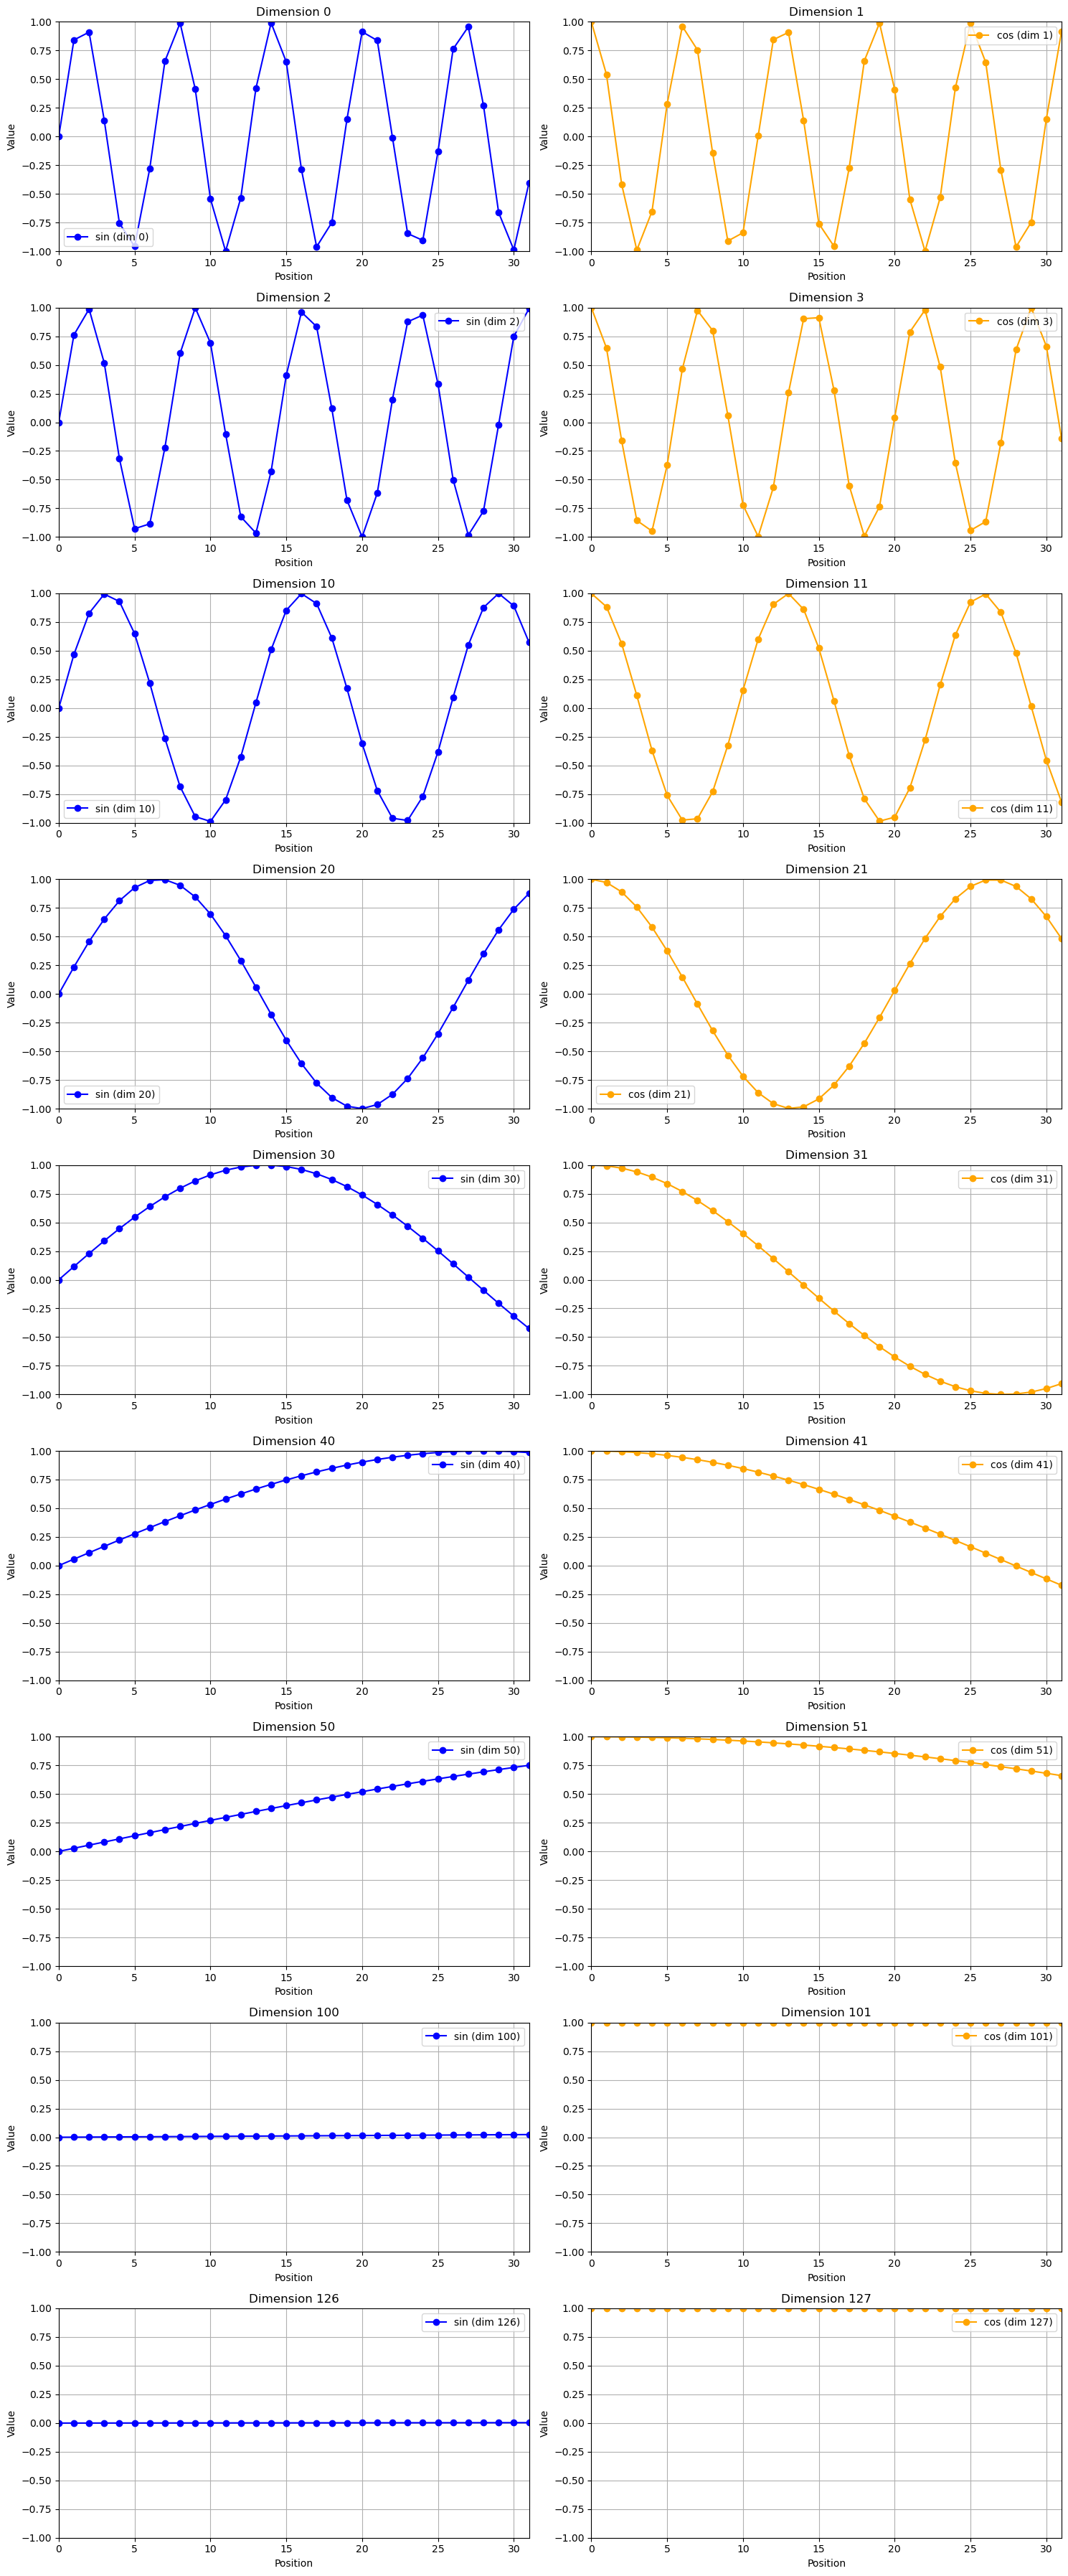

In [49]:
def visualize_positional_encodings(posenc_matrix):
    import matplotlib.pyplot as plt
    import numpy as np

    # Create positions array for x-axis with actual positions
    positions = np.arange(0, 32)  # 0 to 31 as integers

    # Create new position encodings for actual points
    smooth_encodings = torch.zeros((len(positions), posenc_matrix.shape[1]))
    for pos_idx, pos in enumerate(positions):
        for i in range(posenc_matrix.shape[1] // 2):
            denom = 10000 ** ((2 * i) / posenc_matrix.shape[1])
            smooth_encodings[pos_idx, 2 * i] = math.sin(pos / denom)
            smooth_encodings[pos_idx, 2 * i + 1] = math.cos(pos / denom)

    # Define dimensions to plot (added more intermediate dimensions)
    dims_to_plot = [
        0,
        1,
        2,
        3,
        10,
        11,
        20,
        21,
        30,
        31,
        40,
        41,
        50,
        51,
        100,
        101,
        126,
        127,
    ]

    # Create figure with 9x2 subplots
    fig, axes = plt.subplots(9, 2, figsize=(15, 36))
    axes = axes.ravel()  # Flatten axes for easier indexing

    # Plot each selected dimension
    for i, dim_idx in enumerate(dims_to_plot):
        ax = axes[i]
        if dim_idx % 2 == 0:  # sin
            ax.plot(
                positions,
                smooth_encodings[:, dim_idx],
                label=f"sin (dim {dim_idx})",
                color="blue",
                marker="o",
            )
        else:  # cos
            ax.plot(
                positions,
                smooth_encodings[:, dim_idx],
                label=f"cos (dim {dim_idx})",
                color="orange",
                marker="o",
            )

        ax.set_title(f"Dimension {dim_idx}")
        ax.set_xlabel("Position")
        ax.set_ylabel("Value")
        ax.grid(True)
        ax.legend()
        ax.set_xlim(0, 31)  # Show full position range with small padding
        ax.set_ylim(-1, 1)  # Set y-axis limits

    plt.tight_layout()
    plt.show()


# Visualize the encodings
visualize_positional_encodings(pos_enc)

In [ ]:
# # 1) Create model and move to GPU Observe its architecture - 440 Mib
# untrained_model = BertPooler(config).to(DEVICE)
# print(untrained_model)

# Model Training

In [6]:
# Train with adjusted batch size
trained_model = train_model(
    untrained_model,
    train_loader,
    val_loader,
    DEVICE,
    batch_size=batch_size,
    lr=lr,
    mu=mu,
    max_epochs=epochs,
    patience=patience,
    save_int=save_int,
    save_dir=save_dir,
    save_name=save_name,
    config=config,
)

Epoch 0


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.09s/it]


Train Loss: 1.3913556337356567, Perplexity: 1.000006956802367
Val Loss: 1.3667984008789062, Perplexity: 1.000006834015356


Epoch 1


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.35s/it]


Train Loss: 1.376751720905304, Perplexity: 1.0000068837822977
Val Loss: 1.3074920177459717, Perplexity: 1.000006537481458


Epoch 2


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.36s/it]


Train Loss: 1.2315647602081299, Perplexity: 1.0000061578427604
Val Loss: 0.8513704538345337, Perplexity: 1.0000042568613297


Epoch 3


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.49s/it]


Train Loss: 0.8314235508441925, Perplexity: 1.0000041571263951
Val Loss: 0.5750728249549866, Perplexity: 1.0000028753682586


Epoch 4


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.42s/it]


Train Loss: 0.5837427079677582, Perplexity: 1.0000029187177992
Val Loss: 0.44199296832084656, Perplexity: 1.0000022099672836


Epoch 5


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.55s/it]


Train Loss: 0.4511537700891495, Perplexity: 1.0000022557713948
Val Loss: 0.3597503900527954, Perplexity: 1.000001798753568


Epoch 6


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.63s/it]


Train Loss: 0.367121085524559, Perplexity: 1.0000018356071123
Val Loss: 0.3040100634098053, Perplexity: 1.0000015200514722


Epoch 7


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.37s/it]


Train Loss: 0.3147481232881546, Perplexity: 1.0000015737418548
Val Loss: 0.2640783190727234, Perplexity: 1.0000013203924671


Epoch 8


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.46s/it]


Train Loss: 0.2736339718103409, Perplexity: 1.000001368170795
Val Loss: 0.23374982178211212, Perplexity: 1.0000011687497918


Epoch 9


Validation Processing: 100%|██████████| 1/1 [00:15<00:00, 15.49s/it]


Train Loss: 0.24350056052207947, Perplexity: 1.0000012175035438
Val Loss: 0.20963366329669952, Perplexity: 1.0000010481688657

Model Saved


TRAINING DONE at epoch 9, best epoch 9
Train Loss = 0.24350056052207947, Perplexity = 1.0000012175035438
Val Loss = 0.20963366329669952, Perplexity = 1.0000010481688657


# Evaluation

## Single Example


Filename: ../data/manual_train/dlportfoliobydelinquencystatus.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(0,0): 0.91151005029678344727
(5,2): 0.91151124238967895508
(39,0): 0.91151231527328491211
(5,0): 0.91151243448257446289
(4,12): 0.91151463985443115234
(36,0): 0.91151529550552368164
(8,1): 0.91151541471481323242
(4,4): 0.91151583194732666016
(6,1): 0.91151589155197143555
(9,1): 0.91151630878448486328
(4,2): 0.91151678562164306641
(4,8): 0.91151708364486694336
(24,0): 0.91151732206344604492
(32,0): 0.91151762008666992188
(37,1): 0.91151767969131469727
(20,0): 0.91151827573776245117
(12,0): 0.91151869297027587891
(4,6): 0.91151887178421020508
(8,0): 0.91151899099349975586
(6,0): 0.91151934862136840820
(4,10): 0.91151946783065795898

NB to B ratio: Predicted = 9881:119 | Actual = 9882:118
Accuracy: 99.99% | Precision: 99.16% | Recall: 100.00% | F1-Score: 1.00



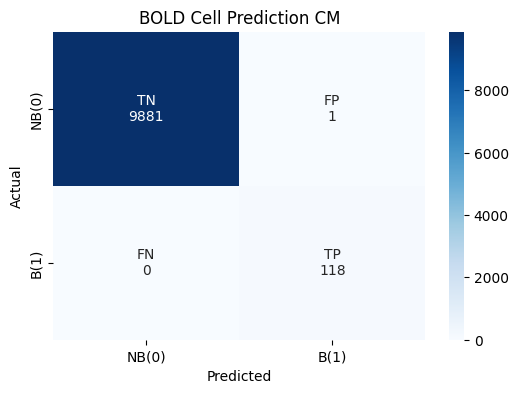


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# Params
loc = 0
thresh = 0.9

# Inference on single position of train_loader
infer_one(
    trained_model=trained_model,
    infer_loader=train_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)


Filename: ../data/manual_val/ffelbydefermenttype.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(0,0): 0.91148203611373901367
(6,3): 0.91151005029678344727
(6,2): 0.91151124238967895508
(6,0): 0.91151243448257446289
(5,2): 0.91151291131973266602
(31,0): 0.91151529550552368164
(7,1): 0.91151541471481323242
(5,4): 0.91151559352874755859
(9,1): 0.91151589155197143555
(5,6): 0.91151601076126098633
(8,1): 0.91151630878448486328
(5,16): 0.91151672601699829102
(19,0): 0.91151732206344604492
(27,0): 0.91151762008666992188
(15,0): 0.91151827573776245117
(5,8): 0.91151851415634155273
(5,14): 0.91151869297027587891
(5,12): 0.91151887178421020508
(5,10): 0.91151928901672363281

NB to B ratio: Predicted = 9895:105 | Actual = 9896:104
Accuracy: 99.99% | Precision: 99.05% | Recall: 100.00% | F1-Score: 1.00



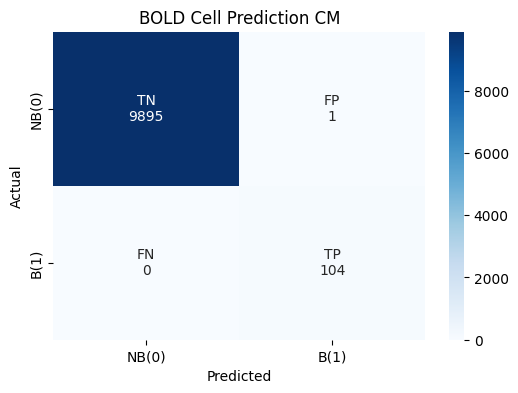


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# Inference on single position of val_loader
infer_one(
    trained_model=trained_model,
    infer_loader=val_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)


Filename: ../data/manual_test/dlportfoliobyrepaymentplan.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(5,18): 0.15308873355388641357
(5,4): 0.90371614694595336914
(5,2): 0.90957540273666381836
(5,14): 0.91046625375747680664
(5,16): 0.91048598289489746094
(5,8): 0.91139239072799682617
(5,6): 0.91142243146896362305
(6,3): 0.91151005029678344727
(6,2): 0.91151124238967895508
(0,0): 0.91151225566864013672
(6,0): 0.91151243448257446289
(37,0): 0.91151529550552368164
(9,1): 0.91151541471481323242
(7,1): 0.91151589155197143555
(10,1): 0.91151630878448486328
(5,12): 0.91151702404022216797
(25,0): 0.91151732206344604492
(33,0): 0.91151762008666992188
(5,10): 0.91151809692382812500
(21,0): 0.91151827573776245117
(5,20): 0.91151869297027587891
(29,0): 0.91151887178421020508
(9,0): 0.91151899099349975586
(7,0): 0.91151934862136840820

NB to B ratio: Predicted = 9843:157 | Actual = 9872:128
Accuracy: 99.67% | Precision: 80.25% | Recall: 98.44% | F1-Score: 0.88



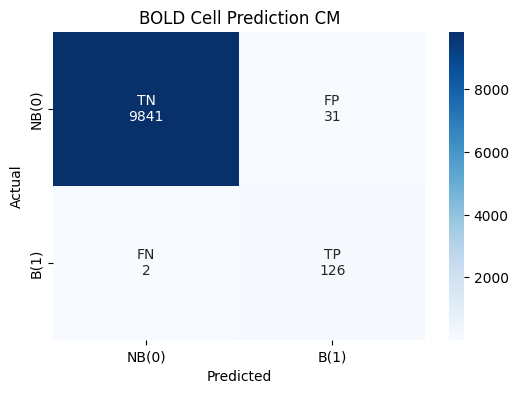


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
8,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
10,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
12,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# Inference on single position of test_loader
infer_one(
    trained_model=trained_model,
    infer_loader=test_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)

## All Examples

Batch Inference: 100%|██████████| 1/1 [00:15<00:00, 15.38s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 396665:3335 | Actual = 396714:3286
Accuracy: 99.99% | Precision: 98.53% | Recall: 100.00% | F1-Score: 0.99



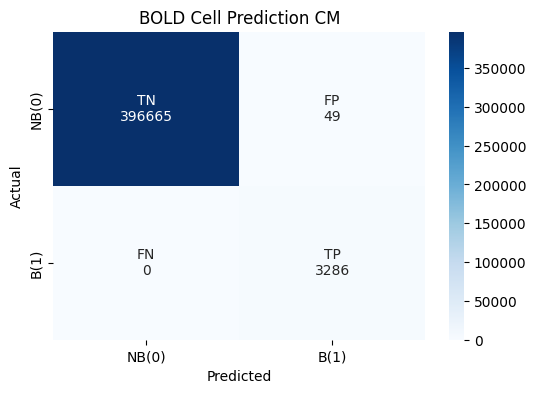

In [10]:
# Determine batch size to use for inference
infer_batch_size = 40

# Infer across all examples of train_loader
infer_full(
    trained_model=trained_model,
    infer_loader=train_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)

Batch Inference: 100%|██████████| 1/1 [00:14<00:00, 14.92s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49597:403 | Actual = 49602:398
Accuracy: 99.99% | Precision: 98.76% | Recall: 100.00% | F1-Score: 0.99



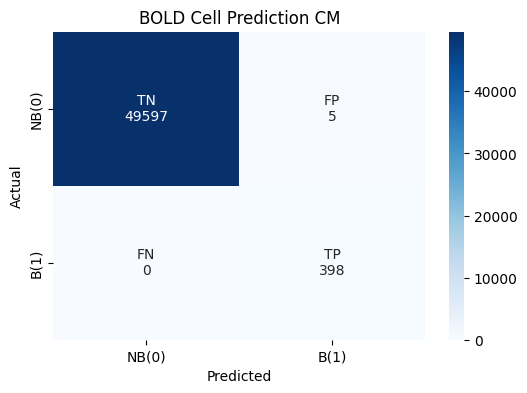

In [11]:
# Infer across all examples of val_loader
infer_full(
    trained_model=trained_model,
    infer_loader=val_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)

Batch Inference: 100%|██████████| 1/1 [00:14<00:00, 14.97s/it]


--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 49572:428 | Actual = 49606:394
Accuracy: 99.92% | Precision: 91.59% | Recall: 99.49% | F1-Score: 0.95



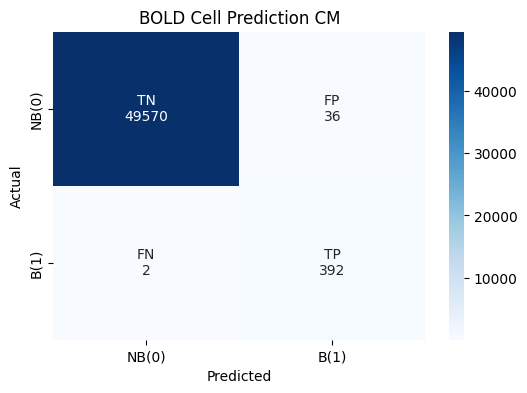

In [12]:
# Infer across all examples of test_loader
infer_full(
    trained_model=trained_model,
    infer_loader=test_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)